In [5]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar

In [6]:
# Cell 2: Load preprocessed data
df = pd.read_csv(r"C:\Users\nimak\Documents\Projects\bank-marketing-classification\data\bank_marketing_processed.csv")

X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (32950, 63), Test shape: (8238, 63)


In [7]:
# Cell 3: Define baseline classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM (Linear Kernel)': SVC(kernel='linear', probability=True)
}


Training and evaluating: Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.71      0.44      0.54       928

    accuracy                           0.92      8238
   macro avg       0.82      0.71      0.75      8238
weighted avg       0.91      0.92      0.91      8238



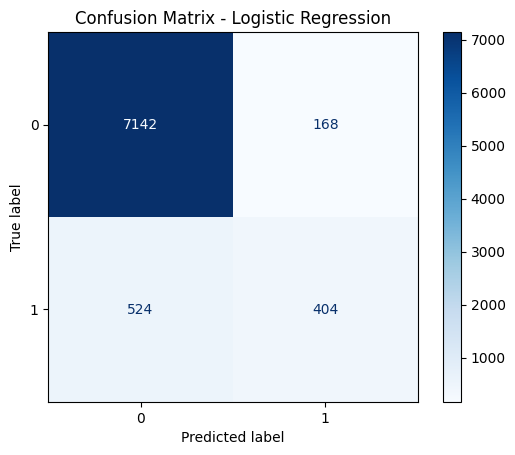


Training and evaluating: Linear Discriminant Analysis
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.65      0.51      0.57       928

    accuracy                           0.91      8238
   macro avg       0.79      0.74      0.76      8238
weighted avg       0.91      0.91      0.91      8238



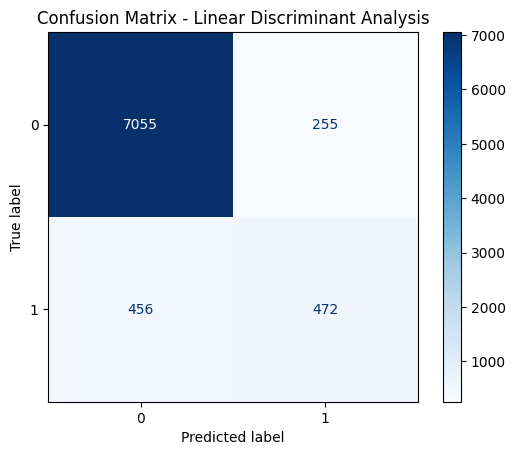


Training and evaluating: k-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.63      0.45      0.52       928

    accuracy                           0.91      8238
   macro avg       0.78      0.71      0.73      8238
weighted avg       0.90      0.91      0.90      8238



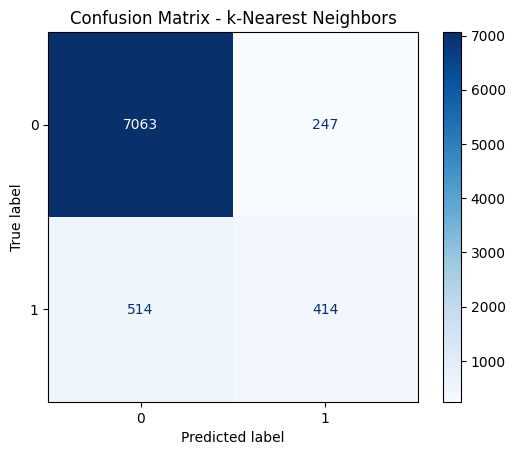


Training and evaluating: Naive Bayes
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      7310
           1       0.35      0.69      0.46       928

    accuracy                           0.82      8238
   macro avg       0.65      0.76      0.68      8238
weighted avg       0.89      0.82      0.84      8238



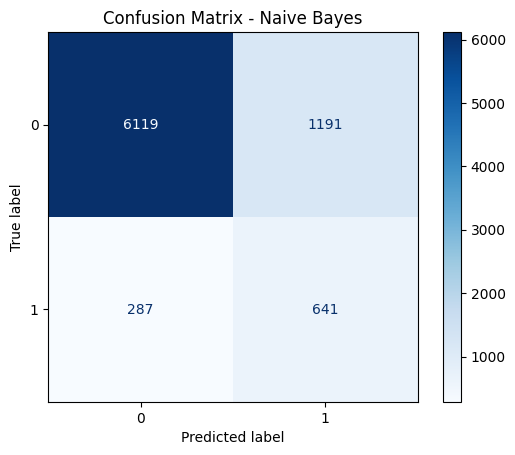


Training and evaluating: SVM (Linear Kernel)
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7310
           1       0.67      0.32      0.43       928

    accuracy                           0.91      8238
   macro avg       0.80      0.65      0.69      8238
weighted avg       0.89      0.91      0.89      8238



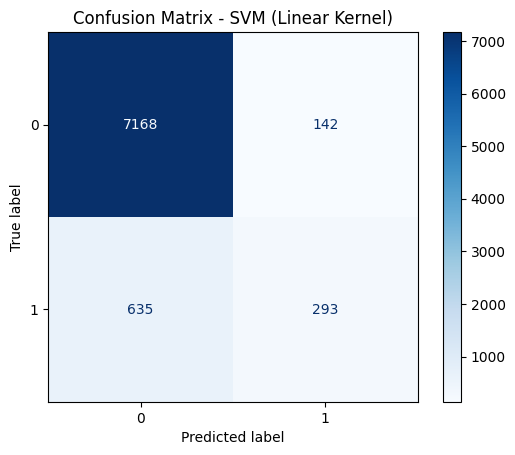

In [10]:
# Cell 4: Train, evaluate classifiers and collect metrics and predictions
results = []
predictions = {}

for name, clf in classifiers.items():
    print(f"\nTraining and evaluating: {name}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    predictions[name] = y_pred
    
    acc = np.round(clf.score(X_test, y_test), 4)
    prec = np.round(pd.Series(y_pred).corr(y_test), 4)  # Just a placeholder, better to calculate precision explicitly
    prec = np.round(np.mean(y_pred[y_test == 1] == 1), 4)  # correct precision calculation below
    
    # Better precision, recall, f1 from sklearn
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision (class 1)': prec,
        'Recall (class 1)': rec,
        'F1-score (class 1)': f1
    })
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


In [9]:
# Cell 5: Create summary results DataFrame
results_df = pd.DataFrame(results)
print("\nSummary of classifier performance:")
display(results_df)


Summary of classifier performance:


,Model,Accuracy,Precision (class 1),Recall (class 1),F1-score (class 1)
0,Logistic Regression,0.9160,0.706294,0.435345,0.538667
1,Linear Discriminant Analysis,0.9137,0.649243,0.508621,0.570393
2,k-Nearest Neighbors,0.9076,0.626324,0.446121,0.521082
3,Naive Bayes,0.8206,0.349891,0.690733,0.464493
4,SVM (Linear Kernel),0.9057,0.673563,0.315733,0.429934


In [13]:
# Cell 6: Traditional McNemar’s test (manual chi-squared)

from sklearn.metrics import accuracy_score

model_names = list(predictions.keys())
mcnemar_stat = pd.DataFrame(index=model_names, columns=model_names)

def traditional_mcnemar_stat(y_true, pred1, pred2):
    # e01: model1 is correct, model2 is wrong
    e01 = np.sum((pred1 == y_true) & (pred2 != y_true))
    # e10: model1 is wrong, model2 is correct
    e10 = np.sum((pred1 != y_true) & (pred2 == y_true))

    if e01 + e10 == 0:
        return "N/A"  # Avoid divide by zero
    chi2 = ((abs(e01 - e10) - 1) ** 2) / (e01 + e10)
    return round(chi2, 4)

# Fill the table with McNemar chi2 stats
for i in model_names:
    for j in model_names:
        if i == j:
            mcnemar_stat.loc[i, j] = np.nan
        else:
            stat = traditional_mcnemar_stat(y_test.values, predictions[i], predictions[j])
            mcnemar_stat.loc[i, j] = stat

print("🧪 McNemar Test Statistic (Chi-Square):")
display(mcnemar_stat)


🧪 McNemar Test Statistic (Chi-Square):


,Logistic Regression,Linear Discriminant Analysis,k-Nearest Neighbors,Naive Bayes,SVM (Linear Kernel)
Logistic Regression,NaN,1.7901,10.0741,439.5328,27.4553
Linear Discriminant Analysis,1.7901,NaN,4.9607,443.5042,13.0401
k-Nearest Neighbors,10.0741,4.9607,NaN,359.7586,0.4767
Naive Bayes,439.5328,443.5042,359.7586,NaN,340.9882
SVM (Linear Kernel),27.4553,13.0401,0.4767,340.9882,NaN
